# Training t-SNE on activations in bottleneck of autoencoder

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow.keras as ks

In [33]:
def plot_tsne_scatter_images_grid(df, n_x=10, n_y=10):
    '''Function takes pandas DataFrame df, which contains at least the following columns:
    x: x-coordinate of t-SNE result
    y: y-coordinate of t-SNE result
    images: images on which previously t-SNE was performed, must be plottable with .imshow()
    target: categories of images (for colors in scatter plot).
    Parameters n_x and n_y define how many images in that direction should be plotted.'''
    # Calculate and store min/max mvalues of both axes in tsne result
    x_min = df.x.min()
    x_max = df.x.max()
    y_min = df.y.min()
    y_max = df.y.max()
    # Calculate span of tsne values in x and y direction
    x_span = x_max - x_min
    y_span = y_max - y_min
    
    # Create figure with one axis to plot scatter plot ot tsne result
    fig, ax = plt.subplots(figsize=(10, 10))

    # Increasing resolution
    #plt.figure(dpi=1200)
    # Set title 
    plt.title('Plot one example image for grid over t-SNE result')
    # Set axes titles
    plt.xlabel('x-coordinate of t-SNE')
    plt.ylabel('y-coordinate of t-SNE')

    # Set axis to min/max values in tsne result
    ax.set_xlim(left=x_min, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)
    # Plot scatter plot ot tsne result and colorize points to their label
    ax.scatter(df.x, df.y, c=df.target, cmap='magma', s=8)

    
    # Define grid to place image plots on
    grid = fig.add_gridspec(n_x, n_y)


    # Define two loops, to iterate over grid
    for i in range(n_x):
        for j in range(n_y):
            # Calculate edges of current grid cell in "tsne-space"
            x_edge_lower = x_min + i * x_span/n_x
            x_edge_upper = x_min + (i+1) * x_span/n_x
            y_edge_lower = y_max - (j+1) * y_span/n_y
            y_edge_upper = y_max - j * y_span/n_y
            # Slice tsne_result and extract index, to find data positions of data within current cell
            index_in_cell = df[(x_edge_lower < df.x) & 
                                    (df.x < x_edge_upper) &
                                    (y_edge_lower < df.y) & 
                                    (df.y < y_edge_upper)].index
            # Check, if at least one hit is in current grid cell
            if index_in_cell.values.size > 0:
                # Create axis at current position in grid
                ax_pic = fig.add_subplot(grid[j, i])
                # Disable x- and y-ticks on image plot axis
                plt.setp(ax_pic, xticks=[], yticks=[])
                # Plot iamge of first (of possible more) datasets in current cell
                ax_pic.imshow(df.images[index_in_cell.values[0]], cmap='gray')

### Load image dataset CIFAR10

In [3]:
# Loading data
(x_train, y_cat_train), (x_test, y_cat_test) = ks.datasets.cifar10.load_data()
# Normalizing to values from 0 to 1, reducing to 20.000 sample images
x_train = x_train.astype('float')/ 255 
y_train = x_train.copy() # Target is same as input for autoencoders
# Normalizing test data set the same way
x_test = x_test.astype('float') / 255

### Setting up and training autoencoder network on training images

In [130]:
# Defining activation function to be used in autoencoder
activ = 'selu'

# Setting up convolutional autoencoder
Net = ks.Sequential()
Net.add(ks.layers.Conv2D(16, 3, activation=activ, padding='same', input_shape=(32, 32, 3)))
Net.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 32x32 to 16x16
Net.add(ks.layers.Conv2D(32, 3, activation=activ, padding='same'))
Net.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 16x16 to 8x8
Net.add(ks.layers.Conv2D(64, 3, activation=activ, padding='same'))
Net.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 8x8 to 4x4
Net.add(ks.layers.Conv2D(8, 3, activation=activ, padding='same')) # Bottleneck with 8 channels 4x4 px = 128 neurons
Net.add(ks.layers.UpSampling2D(size=(2, 2))) # From 4x4 to 8x8
Net.add(ks.layers.Conv2D(64, 3, activation=activ, padding='same'))
Net.add(ks.layers.UpSampling2D(size=(2, 2))) # From 8x8 to 16x16
Net.add(ks.layers.Conv2D(32, 3, activation=activ, padding='same'))
Net.add(ks.layers.UpSampling2D(size=(2, 2))) # From 16x16 to 32x32
Net.add(ks.layers.Conv2D(16, 3, activation=activ, padding='same'))
Net.add(ks.layers.Conv2D(3, 5, activation='sigmoid', padding='same')) # Output layer with 3 color channels

# Defining loss-function and optimizer
Net.compile(loss='MeanSquaredError', optimizer='adam')
# empty list as storage for loss information
history_buffer = []

In [8]:
# Fitting model to training data
history = Net.fit(x_train, y_train, batch_size=10, epochs=40)
# Storing information about loss
history_buffer += history.history['loss']

Epoch 1/40
5000/5000 [==============================] - 33s 6ms/step - loss: 0.0093
Epoch 2/40
5000/5000 [==============================] - 31s 6ms/step - loss: 0.0069
Epoch 3/40
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0065
Epoch 4/40
5000/5000 [==============================] - 32s 6ms/step - loss: 0.0063
Epoch 5/40
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0061
Epoch 6/40
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0061
Epoch 7/40
5000/5000 [==============================] - 31s 6ms/step - loss: 0.0060
Epoch 8/40
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0060
Epoch 9/40
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0059
Epoch 10/40
5000/5000 [==============================] - 31s 6ms/step - loss: 0.0059
Epoch 11/40
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0059
Epoch 12/40
5000/5000 [==============================] - 30s 6ms/step - lo

Text(0.5, 0.98, 'Loss function')

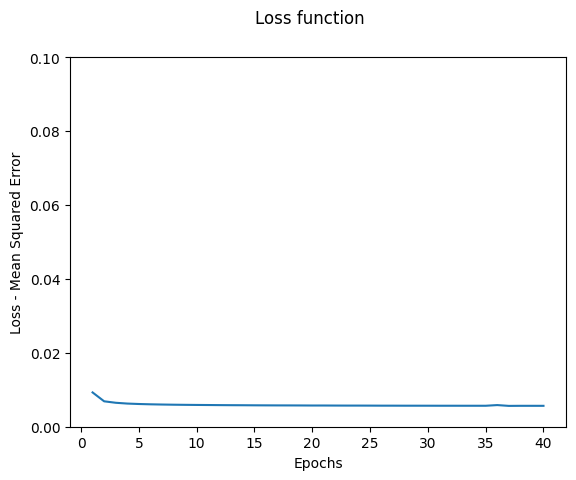

In [9]:
# Plotting loss function
fig, ax = plt.subplots()
ax.set_ylim(bottom=0, top=np.max(history_buffer).round(1) + 0.1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss - Mean Squared Error')
ax.plot(list(range(1, len(history_buffer) + 1)), history_buffer)
fig.suptitle('Loss function')

In [10]:
# Check for overfitting by calculating loss for testing data set
y_test = x_test.copy() # input equals output for outoencoders
Net.evaluate(x_test, y_test)

313/313 [==============================] - 3s 7ms/step - loss: 0.0057


0.0056732711382210255

1/1 [==============================] - 0s 133ms/step


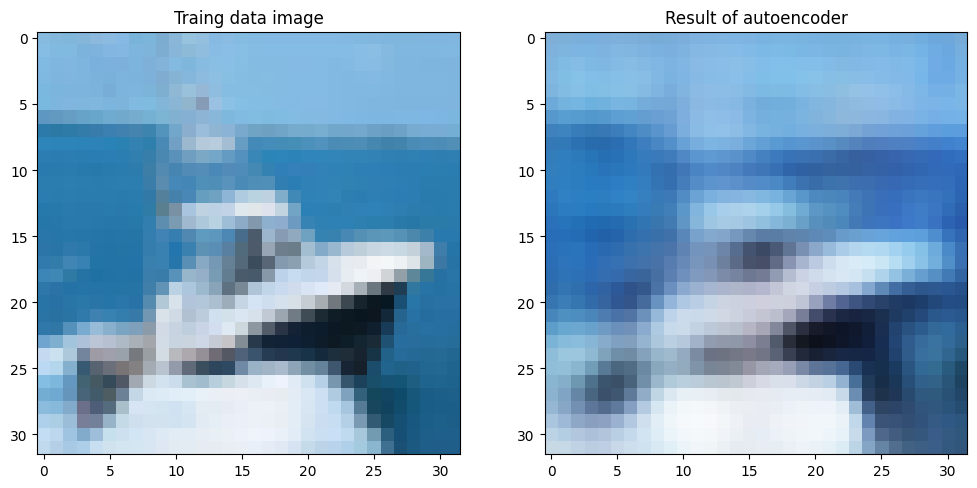

In [11]:
# Visualize result for samples of training data set

# Calculate prediction for training data set (first 10)
predicts_train = Net.predict(x_train[:10])

i = 8 #index to step through training data set for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 26))
axs[0].set_title('Traing data image')
axs[1].set_title('Result of autoencoder')
axs[0].imshow(x_train[i], label='Training data image')
axs[1].imshow(predicts_train[i], label='Result of autoencoder')

1/1 [==============================] - 0s 34ms/step


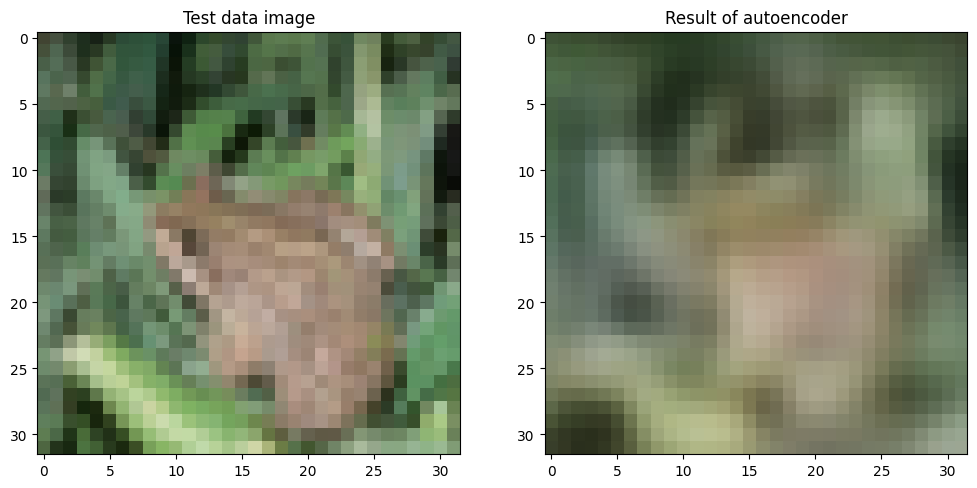

In [8]:
# Visualize result for samples of test data set

# Calculate prediction for test data set (first 10)
predicts_test = Net.predict(x_test[:10])

i = 4 #index to step through training data set for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 26))
axs[0].set_title('Test data image')
axs[1].set_title('Result of autoencoder')
axs[0].imshow(x_test[i], label='Test data image')
axs[1].imshow(predicts_test[i], label='Result of autoencoder')

In [15]:
# Saving trained net to file
#Net.save('trained_autoencoder')

### Extracting bottleneck layer activations from trained autoencoder

In [4]:
# Loading model already trained to save time
Net = ks.models.load_model('autoencoder_trained')

# Setting up network similar to Net, but truncated at bottleneck. Will filled with trained weights
activ_enc = 'selu'

Encoder = ks.Sequential()
Encoder.add(ks.layers.Conv2D(16, 3, activation=activ_enc, padding='same', input_shape=(32, 32, 3), 
                            weights=Net.layers[0].get_weights()))
Encoder.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 32x32 to 16x16
Encoder.add(ks.layers.Conv2D(32, 3, activation=activ_enc, padding='same', 
                            weights=Net.layers[2].get_weights()))
Encoder.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 16x16 to 8x8
Encoder.add(ks.layers.Conv2D(64, 3, activation=activ_enc, padding='same',
                            weights=Net.layers[4].get_weights()))
Encoder.add(ks.layers.AveragePooling2D(padding='same', pool_size=(2, 2))) # from 8x8 to 4x4
Encoder.add(ks.layers.Conv2D(8, 3, activation=activ_enc, padding='same',
                            weights=Net.layers[6].get_weights()))
Encoder.compile(optimizer='adam')

In [132]:
# To check correct operation decoder is set up as well. Later comparisson between applying
# encoder and then decoder to applying trained net as such.

# defining activation function
activ_dec = 'selu'

Decoder = ks.Sequential()
Decoder.add(ks.layers.UpSampling2D(size=(2, 2), input_shape=(4, 4, 8))) # From 4x4 to 8x8
Decoder.add(ks.layers.Conv2D(64, 3, activation=activ_dec, padding='same', 
                             weights=Net.layers[8].get_weights()))
Decoder.add(ks.layers.UpSampling2D(size=(2, 2))) # From 8x8 to 16x16
Decoder.add(ks.layers.Conv2D(32, 3, activation=activ_dec, padding='same', 
                             weights=Net.layers[10].get_weights()))
Decoder.add(ks.layers.UpSampling2D(size=(2, 2))) # From 16x16 to 32x32
Decoder.add(ks.layers.Conv2D(16, 3, activation=activ_dec, padding='same', 
                            weights=Net.layers[12].get_weights()))
Decoder.add(ks.layers.Conv2D(3, 5, activation='sigmoid', padding='same', 
                             weights=Net.layers[13].get_weights())) # Output layer with 3 color channels
Decoder.compile(optimizer='adam')

# Checking correct operation by comparing outputs of Net with output of encoder+decoder for first 10
# test sample pictures.
predicts_test_en_decoder = Decoder.predict(Encoder.predict(x_test[:10]))
print('Is prediction of Net equal to prediction of encoder + decoder: ', 
      np.array_equal(predicts_test, predicts_test_en_decoder))

1/1 [==============================] - 0s 114ms/step


NameError: name 'predicts_test' is not defined

In [5]:
# Storing activations in blottleneck for first 10000 training data images
# Adding layer to flatten outputs
Encoder.add(ks.layers.Flatten())
Encoder.compile(optimizer='adam')
activations_bottleneck = Encoder.predict(x_train[:10000])
# Removing layer to flatten output
Encoder.pop()

313/313 [==============================] - 3s 8ms/step


## T-SNE on bottleneck activations

In [ ]:
np.random.seed(100)

# Perform principal component analyses befor T-SNE
pca = PCA(n_components=50)
pca_cifar10 = pca.fit_transform(activations_bottleneck[:10000])

# Perform T-SNE on result of pca
tsne = TSNE(n_iter=3000, perplexity=50)
tsne_result = tsne.fit_transform(pca_cifar10)

# Plot result if T-SNE
fig, ax = plt.subplots()
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_cat_train[:10000], cmap='magma', s=8)

In [46]:
# Which fraction of explained variance was used, when entering t-SNE?
print('Explained variance (ratio): ', pca.explained_variance_ratio_[:20].sum())

0.6810656

In [14]:
# Create DataFrame holding coordinates of t-SNE result and corresponding CIFAR10-image
df_cifar10 = pd.DataFrame(zip(tsne_result[:, 0], tsne_result[:, 1], x_train[:10000], y_cat_train[:10000]), 
                         columns=['x', 'y', 'images', 'target'])

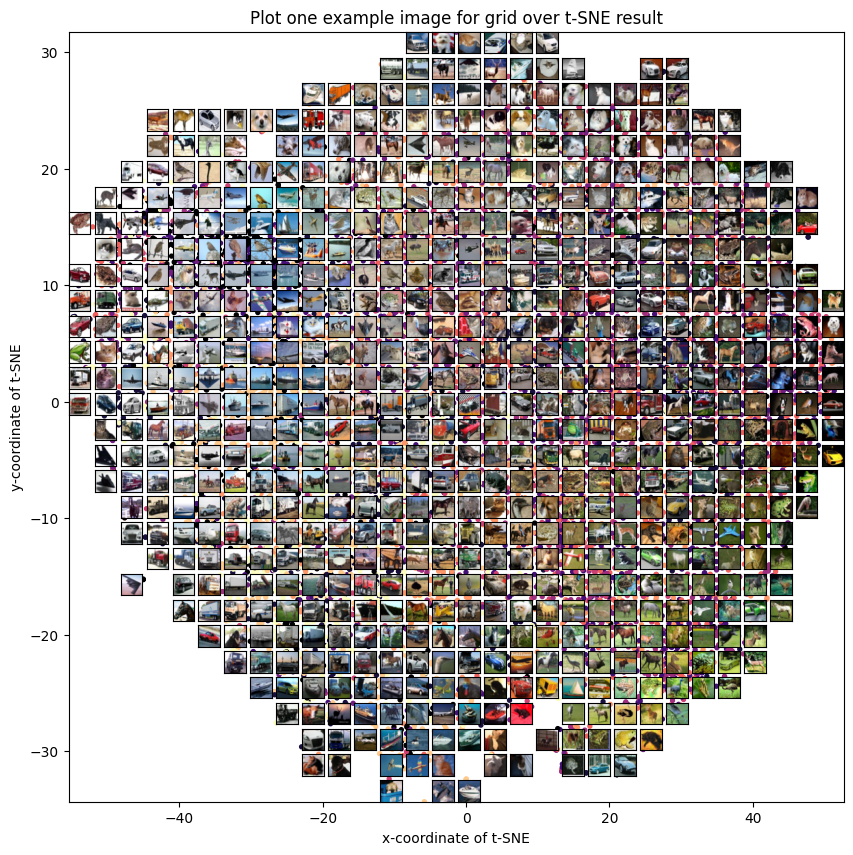

In [20]:
n_x_cifar10 = 30
n_y_cifar10 = 30
plot_tsne_scatter_images_grid(df_cifar10, n_x=n_x_cifar10, n_y=n_y_cifar10)
plt.savefig('Plot_CIFAR10_tSNE_images')

## For comparison: t-SNE on MNIST data set

In [21]:
# Load MNIST dataset
(x_mnist, y_mnist), (_, _) = ks.datasets.mnist.load_data()
# Flatten innermost dimensions to obtain vectors of length no. of pixel
x_input = x_mnist.reshape(60000, 784) / 255

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.756635
[t-SNE] Computed conditional probabilities in 0.031s
[t-SNE] Iteration 50: error = 69.7610016, gradient norm = 0.0001998 (50 iterations in 0.260s)
[t-SNE] Iteration 100: error = 69.6533203, gradient norm = 0.0115035 (50 iterations in 0.144s)
[t-SNE] Iteration 150: error = 69.0909271, gradient norm = 0.0003138 (50 iterations in 0.146s)
[t-SNE] Iteration 200: error = 69.0770798, gradient norm = 0.0000322 (50 iterations in 0.120s)
[t-SNE] Iteration 250: error = 69.0770111, gradient norm = 0.0000397 (50 iterations in 0.128s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.077011
[t-SNE] Iteration 300: error = 1.2167923, gradient norm = 0.0163966 (50 iterations in 0.213s)
[t-SNE] Iteration 350: error = 1.0045323, gradient norm = 0.01133

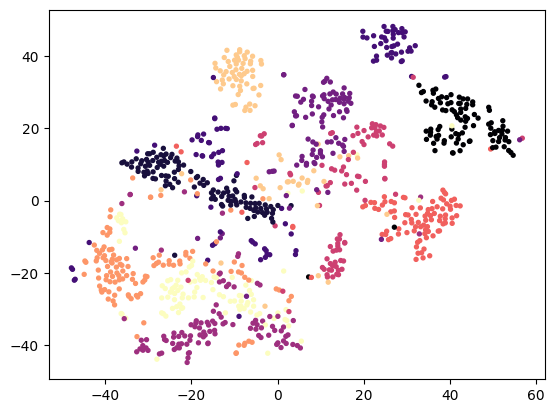

In [43]:
# Reduce dimensionality with critical components analyses first
#pca = PCA(n_components=40)
#pca_mnist = pca.fit_transform(x_input[:1000])

# Set random seed for reproducability
np.random.seed(779)
# Generate instance of TSNE class
tsne_mnist = TSNE(n_iter=4000, perplexity=30, verbose=2)
# Perform t-SNE on some samples
tsne_result = tsne_mnist.fit_transform(x_input[:1000])
# Plot resulting 2D map with colors showing digit number of MNIST image
fig, ax = plt.subplots()
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_mnist[:1000], cmap='magma', s=8)


In [23]:
# Which fraction of explained variance was used, when entering t-SNE?
pca.explained_variance_ratio_[:40].sum()

0.806012938542614

In [38]:
# Create pandas dataframe, to store t-SNE results and corresponding image data
df_tsne = pd.DataFrame(zip(tsne_result[:, 0], tsne_result[:, 1], x_mnist, y_mnist[:1000]), 
             columns=['x', 'y', 'images', 'target'])
df_tsne

,x,y,images,target
0,14.274450,24.024839,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5
1,34.986324,13.545350,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,-12.001723,16.597548,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,-14.645099,-29.982286,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,-24.177502,-1.666575,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",9
...,...,...,...,...
995,-36.233864,1.375295,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7
996,12.850943,6.606364,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6
997,36.649460,5.979339,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
998,11.153972,20.664186,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3


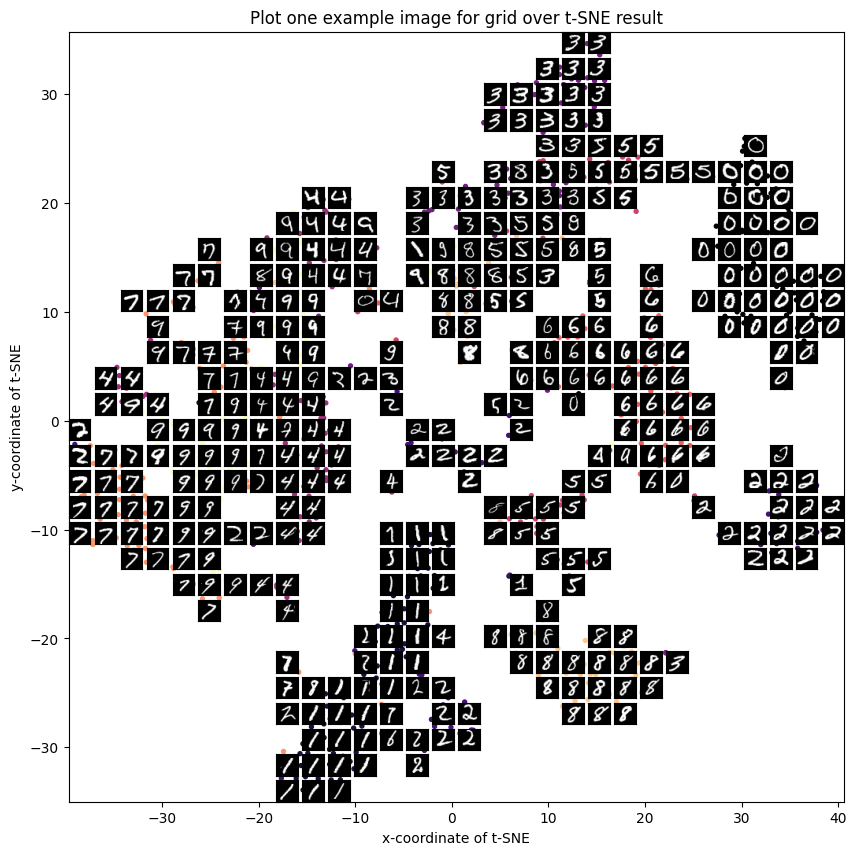

In [45]:
# Define grid with number of pictures in x and y direction
n_x = 30
n_y = 30

plot_tsne_scatter_images_grid(df_tsne, n_x, n_y)
#plt.savefig('Plot_MNIST_tSNE_images')

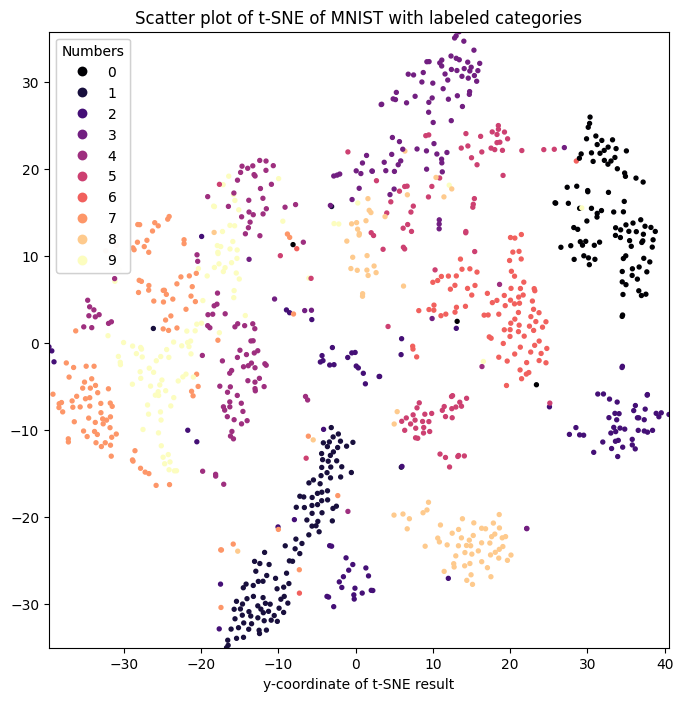

In [44]:
# Plot of MNIST t-SNE result as scatter plot with labeled categories for comparison

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(left=df_tsne.x.min(), right=df_tsne.x.max())
ax.set_ylim(bottom=df_tsne.y.min(), top=df_tsne.y.max())
# Plot scatter plot ot tsne result and colorize points to their label
scatter = ax.scatter(df_tsne.x, df_tsne.y, c=y_mnist[:1000], cmap='magma', s=8)
legend1 = ax.legend(*scatter.legend_elements(), title='Numbers')
plt.xlabel('x-coordinate of t-SNE result')
plt.xlabel('y-coordinate of t-SNE result')
plt.title('Scatter plot of t-SNE of MNIST with labeled categories')
ax.add_artist(legend1)